<a href="https://colab.research.google.com/github/richardtekere09/Image-recognition-methods/blob/main/Plant_leaf_damage_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the libraries

In [1]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


CUSTOM DATASET CLASS

In [2]:
class PlantDataset(Dataset):
    """
    Custom Dataset for loading plant leaf images

    How it works:
    1. Scans folders and creates list of (image_path, label) pairs
    2. __len__ returns total number of images
    3. __getitem__ loads one image when requested
    """
    def __init__(self,root_dir,transform=None):
        """
        Args:
            root_dir (str): Path to Train or Test folder
            transform: PyTorch transforms to apply to images
        """
        self.root_dir=Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        #Map the labels
        self.class_map = {
            'Potato_sick_late': 0,
            'Potato_sick_early': 1,
            'Potato_healthy': 2
        }

        # Scan all folders and collect image paths
        for class_name, label in self.class_map.items():
          class_folder = self.root_dir/ class_name
          if class_folder.exists():
              all_images = (
                    sorted(class_folder.glob("*.jpg")) +    # lowercase
                    sorted(class_folder.glob("*.JPG")) +    # uppercase
                    sorted(class_folder.glob("*.jpeg")) +   # lowercase
                    sorted(class_folder.glob("*.JPEG")) +   # uppercase
                    sorted(class_folder.glob("*.png")) +    # lowercase
                    sorted(class_folder.glob("*.PNG"))      # uppercase
                )

              for img_path in all_images:
                  self.images.append(str(img_path))
                  self.labels.append(label)

        print(f"Loaded {len(self.images)} images from {root_dir}")
        print(f"Class distribution: ", {k: self.labels.count(v) for k, v in self.class_map.items()})

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      img_path =self.images[idx]
      image = Image.open(img_path).convert('RGB')
      label = self.labels[idx]

      # Apply transformations if specified
      if self.transform:
        image = self.transform(image)

      return image ,label


DATA AUGMENTATION & TRANSFORMS

In [3]:
# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.RandomHorizontalFlip(p=0.5),     # 50% chance to flip horizontally
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
        transforms.Normalize(                       # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],            # Standard for pre-trained models
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


LOAD DATASETS

In [4]:
TRAIN_PATH = '/content/drive/MyDrive/plants/Train'
TEST_PATH = '/content/drive/MyDrive/plants/Test'

train_dataset = PlantDataset(TRAIN_PATH, transform=train_transforms)
test_dataset = PlantDataset(TEST_PATH, transform=test_transforms)

# DataLoader: Batches data, shuffles, enables parallel loading
train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    shuffle = True,
    num_workers = 2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=20,
    shuffle = False,
    num_workers = 2
)

Loaded 2100 images from /content/drive/MyDrive/plants/Train
Class distribution:  {'Potato_sick_late': 700, 'Potato_sick_early': 700, 'Potato_healthy': 700}
Loaded 900 images from /content/drive/MyDrive/plants/Test
Class distribution:  {'Potato_sick_late': 300, 'Potato_sick_early': 300, 'Potato_healthy': 300}



DATA CONSISTENCY CHECK

Training batch:
  Images shape: torch.Size([20, 3, 180, 180])
  Labels shape: torch.Size([20])
  Unique labels: [0, 1, 2]
  Label distribution: [(0, 4), (1, 8), (2, 8)]

Test batch:
  Images shape: torch.Size([20, 3, 180, 180])
  Labels shape: torch.Size([20])
  Unique labels: [0]
  Label distribution: [(0, 20)]

✓ Training labels: [0, 1, 2]
✓ Test labels: [0, 1, 2]
✓ PASS: Both datasets have same labels

Visualizing samples...


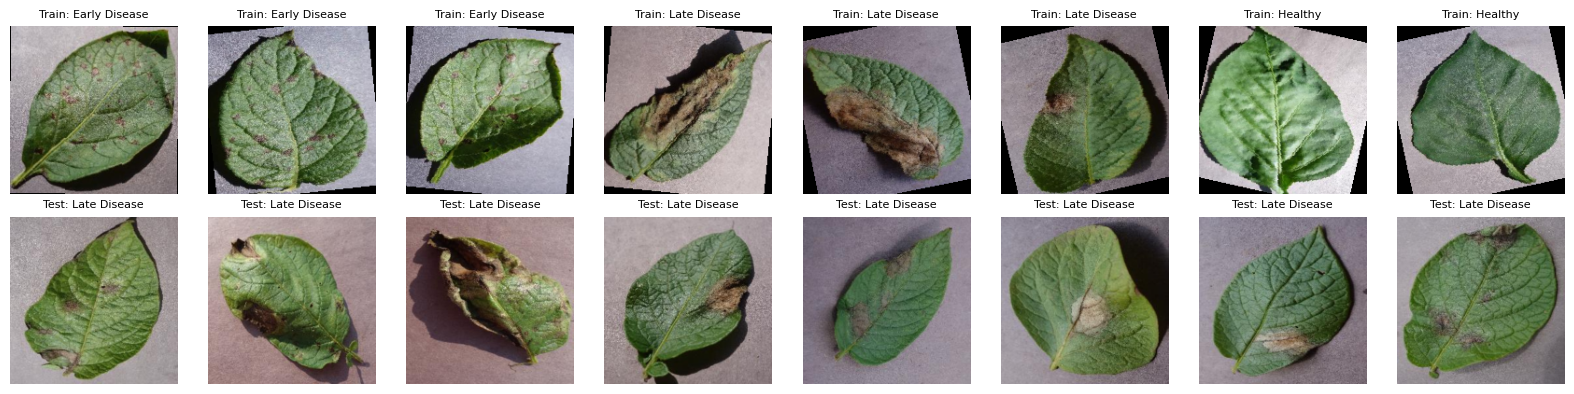

✓ Check complete! Review the images above.


In [12]:
# ════════════════════════════════════════════
# DIAGNOSTIC: Check if labels match
# ════════════════════════════════════════════

def check_data_consistency():
    """Verify training and test data are labeled consistently"""

    print("\n" + "="*60)
    print("DATA CONSISTENCY CHECK")
    print("="*60)

    # Get one batch from each loader
    train_images, train_labels = next(iter(train_loader))
    test_images, test_labels = next(iter(test_loader))

    print(f"\nTraining batch:")
    print(f"  Images shape: {train_images.shape}")
    print(f"  Labels shape: {train_labels.shape}")
    print(f"  Unique labels: {torch.unique(train_labels).tolist()}")
    print(f"  Label distribution: {[(label.item(), (train_labels == label).sum().item()) for label in torch.unique(train_labels)]}")

    print(f"\nTest batch:")
    print(f"  Images shape: {test_images.shape}")
    print(f"  Labels shape: {test_labels.shape}")
    print(f"  Unique labels: {torch.unique(test_labels).tolist()}")
    print(f"  Label distribution: {[(label.item(), (test_labels == label).sum().item()) for label in torch.unique(test_labels)]}")

    # Check if both have same label range
    train_labels_set = set(train_dataset.labels)
    test_labels_set = set(test_dataset.labels)

    print(f"\n✓ Training labels: {sorted(train_labels_set)}")
    print(f"✓ Test labels: {sorted(test_labels_set)}")

    if train_labels_set == test_labels_set:
        print("✓ PASS: Both datasets have same labels")
    else:
        print("✗ FAIL: Label mismatch detected!")
        print(f"  Only in train: {train_labels_set - test_labels_set}")
        print(f"  Only in test: {test_labels_set - train_labels_set}")

    # Visualize some samples
    print("\nVisualizing samples...")
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))

    class_names = ['Late Disease', 'Early Disease', 'Healthy']

    for i in range(8):
        # Training sample
        img = train_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Train: {class_names[train_labels[i]]}', fontsize=8)
        axes[0, i].axis('off')

        # Test sample
        img = test_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Test: {class_names[test_labels[i]]}', fontsize=8)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('data_check.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Check complete! Review the images above.")
    print("="*60)

# Run the check
check_data_consistency()

DEFINE CNN ARCHITECTURE


In [13]:
class PlantCNN(nn.Module):
    """
    Convolutional Neural Network for plant classification

    Architecture:
    - 3 Convolutional blocks (Conv -> ReLU -> MaxPool)
    - Flatten
    - 2 Fully connected layers
    - Output: 3 classes
    """

    def __init__(self):
        super(PlantCNN, self).__init__()

        # Convolutional layers extract spatial features
        # Input: 3 channels (RGB), Output: 32 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # MaxPooling reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # ReLU activation introduces non-linearity
        self.relu = nn.ReLU()

        # Dropout prevents overfitting by randomly disabling neurons
        self.dropout = nn.Dropout(0.5)

        # Calculate flattened size: 180 -> 90 -> 45 -> 22 after 3 pooling layers
        # 22 * 22 * 128 = 61952
        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.fc2 = nn.Linear(256, 3)  # 3 output classes

    def forward(self, x):
        # Block 1: Conv -> ReLU -> Pool
        x = self.pool(self.relu(self.conv1(x)))  # (32, 90, 90)

        # Block 2
        x = self.pool(self.relu(self.conv2(x)))  # (64, 45, 45)

        # Block 3
        x = self.pool(self.relu(self.conv3(x)))  # (128, 22, 22)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # (batch_size, 128*22*22)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  # Raw logits (no softmax needed for CrossEntropyLoss)

        return x


# Initialize model
model = PlantCNN().to(device)
print(f"\nModel architecture:\n{model}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")



Model architecture:
PlantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=61952, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

Total trainable parameters: 15,953,987


LOSS FUNCTION & OPTIMIZER

In [16]:
# CrossEntropyLoss: Combines LogSoftmax + NLLLoss
# Perfect for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer: Adaptive learning rate, works well for most cases
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler: Reduces LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

TRAINING FUNCTION

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()  # Set to training mode (enables dropout)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

VALIDATION FUNCTION

In [18]:
def validate(model, loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()  # Set to evaluation mode (disables dropout)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Don't calculate gradients
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

MAIN TRAINING LOOP

In [19]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20):
    """Complete training loop with tracking"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

    print(f"\n{'='*50}")
    print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
    print(f"{'='*50}")

    return history , model


TRAIN THE MODEL

In [23]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

history, model  = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)


STARTING TRAINING

Epoch 1/20
--------------------------------------------------
Train Loss: 0.0063 | Train Acc: 99.76%
Val Loss: 0.0580 | Val Acc: 99.22%
✓ New best model saved! (Val Acc: 99.22%)

Epoch 2/20
--------------------------------------------------
Train Loss: 0.0084 | Train Acc: 99.71%
Val Loss: 0.0778 | Val Acc: 98.89%

Epoch 3/20
--------------------------------------------------
Train Loss: 0.0095 | Train Acc: 99.86%
Val Loss: 0.0684 | Val Acc: 98.67%

Epoch 4/20
--------------------------------------------------
Train Loss: 0.0051 | Train Acc: 99.86%
Val Loss: 0.0699 | Val Acc: 98.56%

Epoch 5/20
--------------------------------------------------
Train Loss: 0.0044 | Train Acc: 99.90%
Val Loss: 0.0628 | Val Acc: 99.00%

Epoch 6/20
--------------------------------------------------
Train Loss: 0.0062 | Train Acc: 99.81%
Val Loss: 0.0670 | Val Acc: 98.56%

Epoch 7/20
--------------------------------------------------
Train Loss: 0.0029 | Train Acc: 99.95%
Val Loss: 0.065

In [24]:
# Verify history is a dictionary
print(f"\nHistory type: {type(history)}")
print(f"History keys: {history.keys() if isinstance(history, dict) else 'Not a dictionary!'}")



History type: <class 'dict'>
History keys: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])


PLOT TRAINING HISTORY

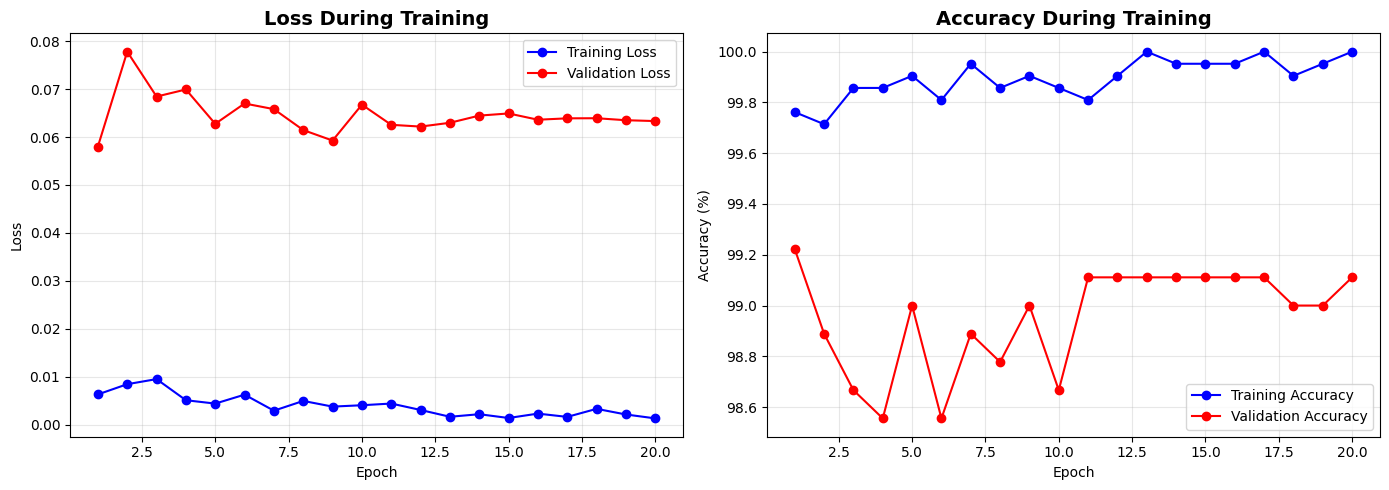

In [25]:
def plot_history(history):
    """Visualize training progress"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Loss During Training', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title('Accuracy During Training', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history)

VISUALIZE PREDICTIONS

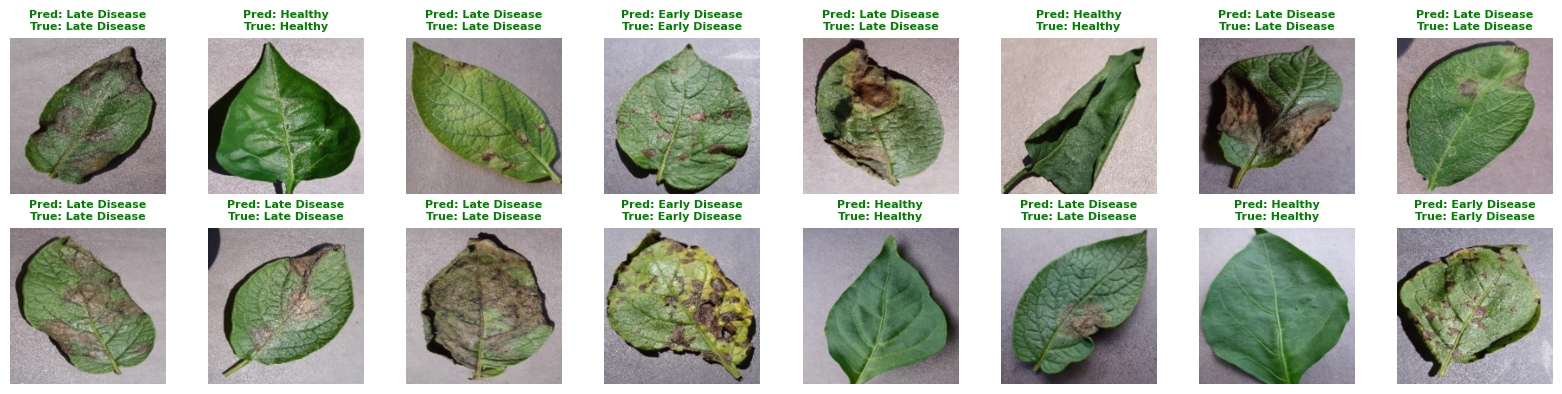

In [26]:
def visualize_predictions(model, dataset, num_images=16):
    """Display model predictions on test images"""
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), num_images, replace=False)

    class_names = ['Late Disease', 'Early Disease', 'Healthy']

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    axes = axes.ravel()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Add batch dimension and predict
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            # Denormalize image for display
            img_display = image.cpu().numpy().transpose(1, 2, 0)
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)

            # Display
            axes[i].imshow(img_display)
            axes[i].axis('off')

            color = 'green' if pred_label == true_label else 'red'
            axes[i].set_title(
                f'Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}',
                fontsize=8,
                color=color,
                fontweight='bold'
            )

    plt.tight_layout()
    plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, test_dataset, num_images=16)

FINAL EVALUATION


FINAL TEST EVALUATION
Test Loss: 0.0633
Test Accuracy: 99.11%

Classification Report:
               precision    recall  f1-score   support

 Late Disease       0.98      0.99      0.99       300
Early Disease       1.00      0.99      0.99       300
      Healthy       1.00      0.99      0.99       300

     accuracy                           0.99       900
    macro avg       0.99      0.99      0.99       900
 weighted avg       0.99      0.99      0.99       900



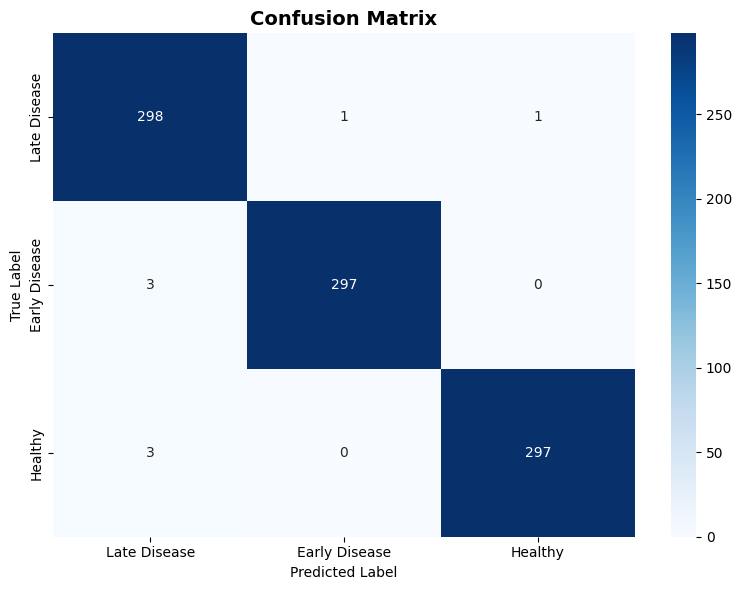


✓ Lab completed successfully!


In [27]:
print("\n" + "="*50)
print("FINAL TEST EVALUATION")
print("="*50)

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Detailed per-class metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def detailed_evaluation(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Classification report
    class_names = ['Late Disease', 'Early Disease', 'Healthy']
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

detailed_evaluation(model, test_loader, device)

print("\n✓ Lab completed successfully!")